In [1]:
import itertools
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

# Ejercicio 1. 

**Estimación de preferencias con la técnica de Conjoint Analysis. Una empresa quiere lanzar un nuevo sistema GPS y quiere hacer un estudio para determinar la mejor configuración del producto. Los atributos del producto y sus posibles valores son:**
- **Sistema GPS: Completamente removible, semi-removible, o integrado**
- **Peso: 8 libras, 5 libras, 3 libras.**
- **Precio: 350$, 450$, 750$**


**Se pide realizar las siguientes tareas:**
- **Determinar los posibles productos que se pueden diseñar en base a las combinaciones de los atributos. Crear una lista de combinaciones de tal forma que aparezca cada valor el mismo número de veces.**

De forma general, si tenemos $n$ atributos con $L_1$, $L_2$, ..., $L_n$ niveles cada uno, entonces el total de perfiles lo calculamos como $\prod_{i = 1}^n L_i$. Cada nivel del atributo $i$ aparece $\prod_{i = i}^n L_i / L_j$ veces.

Hay 3 atributos: 
- Tipo de sistema GPS (3 niveles) 
- Peso (3 niveles)
- Precio (3 niveles)

Así, el número total de combinaciones en un diseño factorial completo es $3\times 3\times 3 = 27$ diseños. En esas 27 combinaciones, cada nivel de cada atributo aparece exactamente $27/3 = 9$ veces lo que asegura que tengamos balance (cada valor del atributo se repite igual número de veces).

In [2]:
# definimos los niveles de cada atributo
niveles = {
    "GPS": ["Completamente removible", "Semi-removible", "Integrado"],
    "Peso": ["8 lbs", "5 lbs", "3 lbs"],
    "Precio": ["350$", "450$", "750$"]
}

# producto cartesiano de los niveles
combinaciones = list(itertools.product(niveles["GPS"], niveles["Peso"], niveles["Precio"]))

df = pd.DataFrame(combinaciones, columns=["GPS", "Peso", "Precio"])
df

,GPS,Peso,Precio
0,Completamente removible,8 lbs,350$
1,Completamente removible,8 lbs,450$
2,Completamente removible,8 lbs,750$
3,Completamente removible,5 lbs,350$
4,Completamente removible,5 lbs,450$
5,Completamente removible,5 lbs,750$
6,Completamente removible,3 lbs,350$
7,Completamente removible,3 lbs,450$
8,Completamente removible,3 lbs,750$
9,Semi-removible,8 lbs,350$


- **Obtener datos de utilidades. Pregunta a un conjunto de personas qué valor de interés o utilidad le daría a cada posible producto. La valoración tendrá un rango de 0 a 10.**

In [3]:
# Definir niveles de atributos y utilidades promedio
mean_part_worths = {
    "GPS": {"Completamente removible": 3, "Semi-removible": 4, "Integrado": 7},
    "Peso": {"8 lbs": 1, "5 lbs": 4, "3 lbs": 5},
    "Precio": {"750$": 2, "450$": 5, "350$": 8}
}

# Generar perfiles factorial completo
perfiles = list(itertools.product(*[d.keys() for d in mean_part_worths.values()]))
df = pd.DataFrame(perfiles, columns=mean_part_worths.keys())

# simulamos utilidades para 10 encuestados
np.random.seed(42)
n_respondents = 10
n_profiles = len(df)

individual_partworths = {}
for attr, levels in mean_part_worths.items():
    individual_partworths[attr] = {
        level: np.random.normal(mean, 1.0, n_respondents) 
        for level, mean in levels.items()
    }

# calculo de utilidades para cada perfil y usuario
utilities = np.zeros((n_profiles, n_respondents))
for i, row in enumerate(df.itertuples(index=False)):
    # Suma de part-worths para cada atributo
    for r in range(n_respondents):
        utilities[i, r] = (individual_partworths["GPS"][row.GPS][r] + 
                           individual_partworths["Peso"][row.Peso][r] + 
                           individual_partworths["Precio"][row.Precio][r])

# ruido aleatorio
utilities += np.random.normal(0, 0.5, utilities.shape)

utils_df = pd.DataFrame(utilities, columns=[f"U{i+1}" for i in range(n_respondents)])
scaled_df = (utils_df
             .apply(lambda col: 10 * (col - col.min()) / (col.max() - col.min()))
             .round()
             .astype(int))

df = pd.concat([df, scaled_df], axis=1)
df

,GPS,Peso,Precio,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10
0,Completamente removible,8 lbs,750$,0,0,0,1,0,0,1,0,0,1
1,Completamente removible,8 lbs,450$,2,3,3,5,0,2,4,1,2,2
2,Completamente removible,8 lbs,350$,3,5,6,7,4,3,7,3,4,6
3,Completamente removible,5 lbs,750$,3,0,2,3,1,4,3,4,3,2
4,Completamente removible,5 lbs,450$,5,5,4,8,0,5,5,5,5,2
5,Completamente removible,5 lbs,350$,7,7,7,8,5,6,8,7,7,6
6,Completamente removible,3 lbs,750$,3,1,2,5,4,4,4,4,3,4
7,Completamente removible,3 lbs,450$,5,5,5,9,4,6,6,5,6,5
8,Completamente removible,3 lbs,350$,7,6,8,9,7,8,9,8,7,9
9,Semi-removible,8 lbs,750$,0,0,0,0,0,1,0,0,0,0


- **Estima la utilidad de cada valor para cada persona calculando la media del interés/utilidad en cada combinación donde aparezca dicho valor.**

In [4]:
util_cols = [col for col in df.columns if col.startswith("U")]

gps_means = df.groupby("GPS")[util_cols].mean().round(2)
peso_means = df.groupby("Peso")[util_cols].mean().round(2)
precio_means = df.groupby("Precio")[util_cols].mean().round(2)

print("Utilidades medias por nivel de GPS:")
display(gps_means)

print("\nUtilidades medias por nivel de Peso:")
display(peso_means)

print("\nUtilidades medias por nivel de Precio:")
display(precio_means)

Utilidades medias por nivel de GPS:


,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10
GPS,,,,,,,,,,
Completamente removible,3.89,3.56,4.11,6.11,2.78,4.22,5.22,4.11,4.11,4.11
Integrado,6.89,6.67,6.22,6.78,5.78,6.89,6.22,6.33,6.89,6.11
Semi-removible,4.00,4.22,4.56,4.33,2.44,4.56,3.78,4.22,4.44,3.56



Utilidades medias por nivel de Peso:


,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10
Peso,,,,,,,,,,
3 lbs,6.00,5.44,5.78,7.44,5.67,7.11,6.00,6.11,6.67,6.33
5 lbs,5.89,5.11,5.44,6.00,3.00,5.67,5.33,6.22,5.89,4.00
8 lbs,2.89,3.89,3.67,3.78,2.33,2.89,3.89,2.33,2.89,3.44



Utilidades medias por nivel de Precio:


,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10
Precio,,,,,,,,,,
350$,6.78,7.22,7.56,7.44,6.11,6.33,8.00,6.89,6.89,7.44
450$,5.11,5.56,5.00,6.67,2.33,5.33,4.89,4.44,5.22,3.67
750$,2.89,1.67,2.33,3.11,2.56,4.00,2.33,3.33,3.33,2.67


- **Estima la utilidad de cada valor para el conjunto de personas encuestado. ¿Difieren estos valores de los valores de utilidad para cada individuo? Si difieren es porque hay perfiles de individuos que son diferentes entre sí y que tienen una visión diferente del producto.**

In [5]:
agg_gps = gps_means.mean(axis=1).round(2)
agg_peso = peso_means.mean(axis=1).round(2)
agg_precio = precio_means.mean(axis=1).round(2)


print("Utilidad promedio agregada por nivel de GPS:")
display(agg_gps.to_frame(name="Utilidad promedio"))

print("\nUtilidad promedio agregada por nivel de Peso:")
display(agg_peso.to_frame(name="Utilidad promedio"))

print("\nUtilidad promedio agregada por nivel de Precio:")
display(agg_precio.to_frame(name="Utilidad promedio"))

Utilidad promedio agregada por nivel de GPS:


,Utilidad promedio
GPS,
Completamente removible,4.22
Integrado,6.48
Semi-removible,4.01



Utilidad promedio agregada por nivel de Peso:


,Utilidad promedio
Peso,
3 lbs,6.26
5 lbs,5.26
8 lbs,3.20



Utilidad promedio agregada por nivel de Precio:


,Utilidad promedio
Precio,
350$,7.07
450$,4.82
750$,2.82


In [6]:
gps_diff = gps_means.subtract(agg_gps, axis=0).round(2)
peso_diff = peso_means.subtract(agg_peso, axis=0).round(2)
precio_diff = precio_means.subtract(agg_precio, axis=0).round(2)

# Mostrar con display()
print("Diferencias respecto a la media agregada por nivel de GPS:")
display(gps_diff)

print("\nDiferencias respecto a la media agregada por nivel de Peso:")
display(peso_diff)

print("\nDiferencias respecto a la media agregada por nivel de Precio:")
display(precio_diff)


Diferencias respecto a la media agregada por nivel de GPS:


,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10
GPS,,,,,,,,,,
Completamente removible,-0.33,-0.66,-0.11,1.89,-1.44,0.00,1.00,-0.11,-0.11,-0.11
Integrado,0.41,0.19,-0.26,0.30,-0.70,0.41,-0.26,-0.15,0.41,-0.37
Semi-removible,-0.01,0.21,0.55,0.32,-1.57,0.55,-0.23,0.21,0.43,-0.45



Diferencias respecto a la media agregada por nivel de Peso:


,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10
Peso,,,,,,,,,,
3 lbs,-0.26,-0.82,-0.48,1.18,-0.59,0.85,-0.26,-0.15,0.41,0.07
5 lbs,0.63,-0.15,0.18,0.74,-2.26,0.41,0.07,0.96,0.63,-1.26
8 lbs,-0.31,0.69,0.47,0.58,-0.87,-0.31,0.69,-0.87,-0.31,0.24



Diferencias respecto a la media agregada por nivel de Precio:


,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10
Precio,,,,,,,,,,
350$,-0.29,0.15,0.49,0.37,-0.96,-0.74,0.93,-0.18,-0.18,0.37
450$,0.29,0.74,0.18,1.85,-2.49,0.51,0.07,-0.38,0.40,-1.15
750$,0.07,-1.15,-0.49,0.29,-0.26,1.18,-0.49,0.51,0.51,-0.15


- **Selecciona ahora un conjunto de personas para probar el poder predictivo de tu modelo. Compara la estimación que da tu modelo con la respuesta real de cada individuo. ¿Qué tal funciona?**

Si el modelo es el de devolver la media:

In [7]:
S = (
    df["GPS"].map(agg_gps) +
    df["Peso"].map(agg_peso) +
    df["Precio"].map(agg_precio)
)

# Paso 2: reescalar S a [0,10]
S_min, S_max = S.min(), S.max()
S_scaled = 10 * (S - S_min) / (S_max - S_min)

# Añadimos la predicción al DataFrame
df["Pred"] = S_scaled

# Paso 3: partición train/test
train_idx, test_idx = train_test_split(df.index, test_size=0.3, random_state=42)

# Paso 4: evaluar RMSE y R2 para cada encuestado
util_cols = [c for c in df.columns if c.startswith("U")]
results = []
for u in util_cols:
    y_true = df.loc[test_idx, u]
    y_pred = df.loc[test_idx, "Pred"]
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results.append({"Encuestado": u, 
                    "Predicción": round(y_pred, 2),
                    "Real": round(y_true, 2),
                    "RMSE": round(rmse, 2), 
                    "R2": round(r2, 2)})

# Mostrar resultados
summary = pd.DataFrame(results).set_index("Encuestado")
display(summary)


,Predicción,Real,RMSE,R2
Encuestado,,,,
U1,8 7.69 13 4.15 9 0.00 21 4.63 0 ...,8 7 13 6 9 0 21 5 0 0 11 ...,0.76,0.91
U2,8 7.69 13 4.15 9 0.00 21 4.63 0 ...,8 6 13 4 9 0 21 4 0 0 11 ...,0.88,0.88
U3,8 7.69 13 4.15 9 0.00 21 4.63 0 ...,8 8 13 5 9 0 21 4 0 0 11 ...,0.80,0.91
U4,8 7.69 13 4.15 9 0.00 21 4.63 0 ...,8 9 13 5 9 0 21 5 0 1 11 ...,1.13,0.85
U5,8 7.69 13 4.15 9 0.00 21 4.63 0 ...,8 7 13 0 9 0 21 4 0 0 11 ...,1.70,0.59
U6,8 7.69 13 4.15 9 0.00 21 4.63 0 ...,8 8 13 5 9 1 21 6 0 0 11 ...,1.19,0.80
U7,8 7.69 13 4.15 9 0.00 21 4.63 0 ...,8 9 13 4 9 0 21 4 0 1 11 ...,0.88,0.91
U8,8 7.69 13 4.15 9 0.00 21 4.63 0 ...,8 8 13 5 9 0 21 6 0 0 11 ...,0.86,0.89
U9,8 7.69 13 4.15 9 0.00 21 4.63 0 ...,8 7 13 5 9 0 21 6 0 0 11 ...,0.74,0.92


Los resultados son, en general, muy buenos para un modelo tan sencillo. Observemos:

- RMSE: oscila entre ~0.7 y 1.7 puntos en la escala 0–10. Valores alrededor de 0.8–1.2 indican que, en promedio, las predicciones se desvían por menos de una unidad de la valoración real, lo cual es claramente aceptable en un contexto de preferencias subjetivas.
- $R^2$: en la mayoría de los casos está por encima de 0.85, alcanzando valores de 0.90–0.92 incluso. Esto significa que entre el 85 % y el 92 % de la variación en las respuestas de cada encuestado se explica solo con la suma de los part-worths promedios reescalados.
- Casos atípicos: U5 destaca con un RMSE de 1.70 y un R² de 0.59, indicando que ese encuestado tiene patrones de puntuación menos alineados con el modelo agregado (quizá valores más dispersos o sesgos individuales muy fuertes). U4, U6, U10 también muestran un ajuste algo peor ($R^2 \sim$ 0.80–0.86), pero siguen siendo razonables.

- **Plantea el problema de la estimación de las utilidades de cada valor como un problema de regresión con la utilidad del producto como variable dependiente de la combinación de los atributos/valores del producto.**

Planteamos la estimación de las utilidades como un problema de regresión lineal, donde la variable dependiente (y) es la utilidad observada para cada perfil (columnas U1, ..., U10), y las variables independientes (X) son dummies de GPS, Preso y Peso, omitiendo la categoría de referencia en cada atributo. Así, para cada perfil Uj ajustamos
\begin{equation*}
y = \beta_0 + \sum \beta_{\text{dummy}} \times \text{dummy} + \epsilon,
\end{equation*}

donde cada coeficiente $\beta$ es el part-worth de cada nivel del atributo, y $\epsilon$ es el error aleatorio. 

El intercepto $\beta_0$ representa la utilidad del perfil base (GPS=completamente removible, Peso=3 lbs, Precio=350 $). Los coeficientes de cada dummy representan el incremento o decremento respecto al perfil base. El $R^2$ es la proporción de varianza explicada por el modelo para cada encuestado.

- **Realiza la estimación de los parámetros del modelo de regresión y compáralos con los resultados obtenidos por Conjoint Analysis.**

In [8]:
X = pd.get_dummies(df[['GPS', 'Peso', 'Precio']], drop_first=True)

train_idx, test_idx = train_test_split(df.index, test_size=0.5, random_state=42)

results_reg = {}
predictions = pd.DataFrame(index=test_idx)

for user in util_cols:
    y_train = df[user].loc[train_idx]
    y_test = df[user].loc[test_idx]

    X_train = X.loc[train_idx]
    X_test = X.loc[test_idx]

    model = LinearRegression().fit(X_train, y_train)
    preds = model.predict(X_test)
    predictions[f"Pred_{user}"] = preds

    results_reg[user] = {
        'Predicho (test)': preds.mean(),
        'Real (test)': y_test.mean(),
        'RMSE (test)': root_mean_squared_error(y_test, preds),
        'R2 (test)': r2_score(y_test, preds)
    }

display(pd.DataFrame(results_reg).T.round(2))

,Predicho (test),Real (test),RMSE (test),R2 (test)
U1,4.17,4.29,0.56,0.94
U2,4.08,4.21,0.70,0.90
U3,4.49,4.50,0.65,0.92
U4,5.14,5.36,0.70,0.93
U5,3.34,2.93,0.83,0.91
U6,4.64,4.64,0.56,0.95
U7,4.63,4.71,0.64,0.94
U8,4.60,4.36,0.46,0.97
U9,4.47,4.57,0.58,0.95
U10,4.09,4.14,0.57,0.96


In [11]:
results_comp = {}
for user in util_cols:
    y_true = df[user].loc[test_idx]

    # regresion
    y_pred_reg = predictions[f"Pred_{user}"]
    rmse_reg = root_mean_squared_error(y_true, y_pred_reg)
    r2_reg = r2_score(y_true, y_pred_reg)

    # cojoint
    y_pred_conj = df["Pred"].loc[test_idx]
    rmse_conj = root_mean_squared_error(y_true, y_pred_conj)
    r2_conj = r2_score(y_true, y_pred_conj)

    results_comp[user] = {
        "RMSE_Conjoint (test)": round(rmse_conj, 2),
        "RMSE_Regresión (test)": round(rmse_reg, 2),
        "R2_Conjoint (test)": round(r2_conj, 2),
        "R2_Regresión (test)": round(r2_reg, 2)
    }

display(pd.DataFrame(results_comp).T.round(2))

,RMSE_Conjoint (test),RMSE_Regresión (test),R2_Conjoint (test),R2_Regresión (test)
U1,0.77,0.56,0.89,0.94
U2,0.89,0.70,0.84,0.90
U3,0.90,0.65,0.85,0.92
U4,1.69,0.70,0.60,0.93
U5,1.99,0.83,0.46,0.91
U6,1.24,0.56,0.75,0.95
U7,1.22,0.64,0.79,0.94
U8,0.90,0.46,0.87,0.97
U9,0.74,0.58,0.91,0.95
U10,1.19,0.57,0.81,0.96


# Ejercicio 2.

**Dibuja una gráfica donde el eje X represente cantidad de dinero de 0 a 10 millones de euros y el eje Y la utilidad del dinero para ti.**

- **¿Cómo representarías la función de utilidad para ti?**

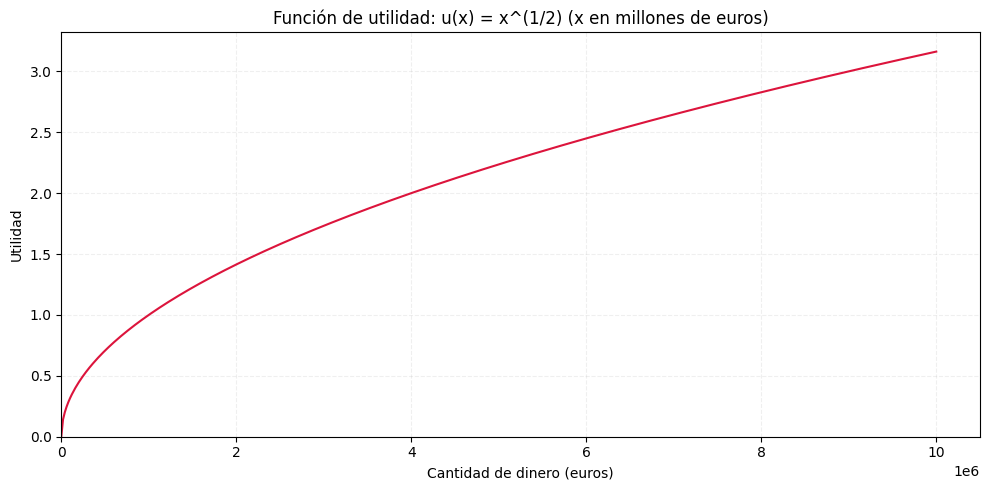

In [39]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 500)
y = np.power(x, 0.5)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x * 1e6, y, color='crimson')

ax.set_xlabel("Cantidad de dinero (euros)")
ax.set_ylabel("Utilidad")
ax.set_title("Función de utilidad: u(x) = x^(1/2) (x en millones de euros)")

ax.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
ax.grid(True, linestyle='--', alpha=0.2)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

- **Suponte que ahora tienes 0 euros en la cuenta. ¿Cambiarías la función de utilidad?**

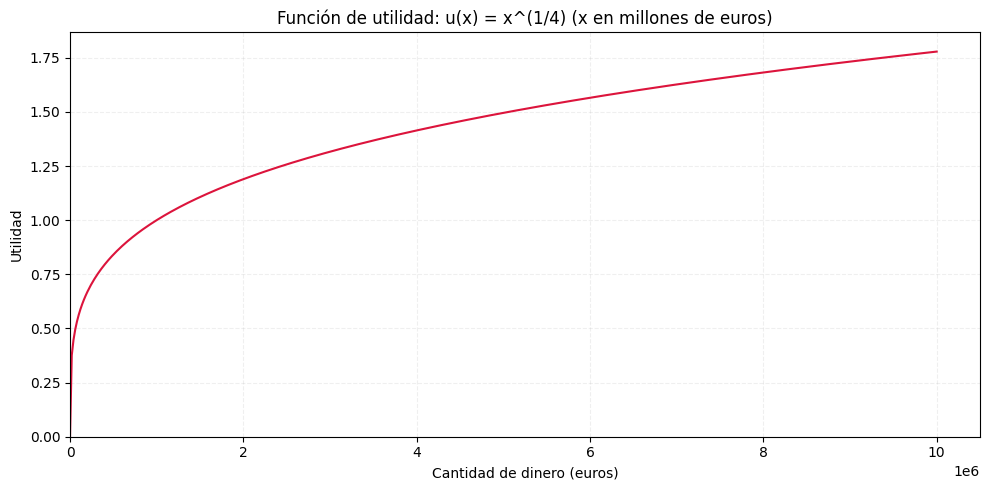

In [45]:
x = np.linspace(0, 10, 500)
y = np.power(x, 0.25)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x * 1e6, y, color='crimson')

ax.set_xlabel("Cantidad de dinero (euros)")
ax.set_ylabel("Utilidad")
ax.set_title("Función de utilidad: u(x) = x^(1/4) (x en millones de euros)")

ax.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
ax.grid(True, linestyle='--', alpha=0.2)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

- **¿Y si tuvieses 1 millón de euros?¿Cómo sería la función?**

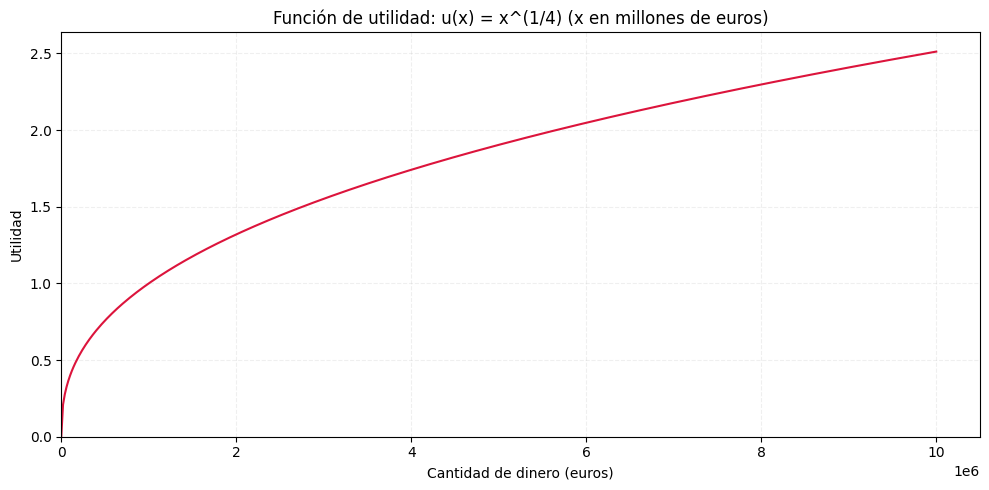

In [ ]:
x = np.linspace(0, 10, 500)
y = np.power(x, 0.5)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x * 1e6, y, color='crimson')

ax.set_xlabel("Cantidad de dinero (euros)")
ax.set_ylabel("Utilidad")
ax.set_title("Función de utilidad: u(x) = x^0.5 (x en millones de euros)")

ax.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
ax.grid(True, linestyle='--', alpha=0.2)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

- **Compara tus impresiones con la teoría sobre utilidad marginal planteada por Bernoulli. Aquí una descripción sencilla de sus ideas:** https://tgmstat.wordpress.com/2014/01/22/declining-marginal-utility-and-the-logarithmic-utility-function/ 

Opino que cuánto menos dinero tengas, mayor utilidad tendrá cualquier incremento de dinero. Bajo un punto de vista objetivo, fijo una función de utilidad $\sqrt{x}$, de forma que la utilidad crece relativamente rápido al inicio, pero se va aplanando a medida que aumenta el dinero. Si tengo 0 euros, obviamente la utilidad del dinero crecerá, por eso pongo como función de utilidad la raíz cuarta en ese caso (crece más rápido al inicio). Si tengo 1 millón de euros, la utilidad del dinero crecerá más lentamente, por eso pongo como función de utilidad, de nuevo, la raíz cuadrada.

Bernouilli propuso una función de utilidad logarítmica, que decrece más lentamente que cualquier potencia. La función de utilidad logarítmica es $U(x) = \ln(x)$, y se utiliza para modelar la aversión al riesgo (mucha) en situaciones donde las colas altas son relevantes. 

En la función que usamos, un exponente menor indica una aversión al riesgo mayor.

# Ejercicio 3.

**Selecciona la opción que te parezca más favorable:**

**Juego 1**

| **Opción A**                                         | **Opción B**                          |
|------------------------------------------------------|---------------------------------------|
| 2 500 € (p = 0,3)<br>2 400 € (p = 0,6)<br>0 € (p = 0,10) | 2 400 € _(seguro, p = 1,00)_           |

**Juego 2**

| **Opción A**                         | **Opción B**                                    |
|--------------------------------------|-------------------------------------------------|
| 2 500 € (p = 0,33)<br>0 € (p = 0,67) | 2 400 € (p = 0,34)<br>0 € (p = 0,66)            |

**Juego 3**

| **Opción A**                         | **Opción B**                          |
|--------------------------------------|---------------------------------------|
| 4 000 € (p = 0,80)<br>0 € (p = 0,20) | 3 000 € _(seguro, p = 1,00)_           |

**Juego 5**

| **Opción A**                                    | **Opción B**                                       |
|-------------------------------------------------|----------------------------------------------------|
| Tour de 3 semanas por Europa (p = 0,50)         | Tour de 1 semana por Europa _(seguro, p = 1,00)_   |

**Juego 7**

| **Opción A**                         | **Opción B**                          |
|--------------------------------------|---------------------------------------|
| 6 000 € (p = 0,45)                   | 3 000 € (p = 0,90)                    |

**Calcula la utilidad utilizando la teoría de la utilidad esperada. ¿Coinciden tus resultados con los resultados teóricos?¿Por qué?**

La teoría de la utilidad esperada establece que la utilidad de una opción es igual a la suma de las utilidades de cada resultado posible, ponderadas por su probabilidad, es decir, 
\begin{equation*}
U(x) = \sum_{i=1}^{n} p_i \cdot u(x_i)
\end{equation*}

In [ ]:
juegos = {
    "Juego 1": {
        "A": [(2500, 0.33),(2400, 0.66),(0, 0.10)],
        "B": [(2400, 1.00)]
    },
    "Juego 2": {
        "A": [(2500, 0.33),(0, 0.67)],
        "B": [(2400, 0.34),(0, 0.66)]
    },
    "Juego 3": {
        "A": [(4000, 0.80),(0, 0.20)],
        "B": [(3000, 1.00)]
    },
    "Juego 5": {
        "A": [(3, 0.50),(0, 0.50)],
        "B": [(1, 1.00)]
    },
    "Juego 7": {
        "A": [(6000, 0.45)],
        "B": [(3000, 0.90)]
    }
}

resultados = []
for nombre, opts in juegos.items():
    euA = sum(valor * prob for valor, prob in opts["A"])
    euB = sum(valor * prob for valor, prob in opts["B"])
    mejor = "A" if euA > euB else ("B" if euB > euA else "Indiferente")
    resultados.append({
        "Juego": nombre,
        "EU(A)": round(euA, 2),
        "EU(B)": round(euB, 2),
        "Elección": mejor
    })

df = pd.DataFrame(resultados)
display(df)

,Juego,EU(A),EU(B),Elección
0,Juego 1,2409.0,2400.0,A
1,Juego 2,825.0,816.0,A
2,Juego 3,3200.0,3000.0,A
3,Juego 5,1.5,1.0,A
4,Juego 7,2700.0,2700.0,Indiferente


**Lee el paper de Kahneman y Tversky donde explican su teoría de por qué la teoría de la utilidad esperada no siempre funciona correctamente. Los juegos planteados aquí se corresponden con los juegos que plantean en su paper. Fíjate si tus resultados coinciden con la mayoría de encuestados por estos autores**

| Juego   | Mi elección | Elección EU | Elección modal en el experimento                      |
| ------- | ----- | ---------------------------- | ----------------------------------------------------- |
| Juego 1 | A | A                            | B: 82 % eligieron la alternativa segura (€ 2 400)     |
| Juego 2 | A | A                            | A: 83 % eligieron la lotería (€ 2 500, p = 0,33)      |
| Juego 3 | B | A                            | B: 80 % prefirieron la alternativa segura (€ 3 000)   |
| Juego 5 | A | A                            | B: 67 % prefirieron el tour seguro de 1 semana        |
| Juego 7 | B | Indiferente                  | B: 86 % prefirieron la opción con p = 0,90 (€ 3 000)  |


# Ejercicio 4.

**Tenemos un conjunto de documentos en una base de datos y queremos clasificarlos automáticamente. La idea es utilizar como datos las palabras que contiene cada documento para realizar la clasificación. Se determinan dos posibles clases o tipos a las cuales asignar los documentos: Clase "Lenguaje/Programación", y la Clase "Serpiente/Animales". Aquí se muestra un ejemplo de clasificación en base a un texto extraído del documento:**

| Features                                                         | Classification |
|------------------------------------------------------------------|---------------:|
| Pythons are constrictors that feed on birds and mammals          | Snake          |
| Python was originally developed as a scripting language          | Language       |
| A 49‑ft.‑long python was found in Indonesia                      | Snake          |
| Python has a dynamic type system                                 | Language       |
| Python with vivid scales                                         | Snake          |
| Open source project                                              | Language       |


**Además se ha analizado un corpus de documentos del que se obtienen los siguientes datos: (1) existe un número similar de documentos en cada una de las clases, y (2) las probabilidades de que una palabra determinada aparezca asociada a una clase u otra son:**

| **Palabra/Atributo** | **Language** | **Snake** |
|:---------------------|-------------:|----------:|
| Dynamic              | 0.6          | 0.1       |
| Constrictor          | 0.0          | 0.6       |
| Long                 | 0.1          | 0.2       |
| Source               | 0.3          | 0.1       |
| And                  | 0.95         | 0.95      |

**Se pide estimar con qué probabilidad se clasificará en un clase u otra, un documento D que contiene las palabras "and" y "constrictor".**

***Nota: Si consideramos independencia entre los atributos $\mathcal{A}_j$ que caracterizan nuestros documentos, entonces la probabilidad $P(D|C_i)$ puede expresarse del siguiente modo:**
\begin{equation*}
P(D|C_i) = \prod_{j=1}^n P(\mathcal{A}_j|C_i)
\end{equation*}

Usamos un Naive Bayes para clasificar el documento $D$ con las palabras "and" y "constrictor". La idea es:
- Antes de clasificar, estimamos la probabilidad de que el documento pertenezca a cada clase (Language o Snake), lo que llamamos priors.
- Luego, estimamos la probabilidad de observar el documento dado cada clase (Language o Snake), lo que llamamos likelihoods.
- Multiplicamos ambas probabilidades para cada clase. 
- Finalmente, dividimos por la suma de esos valores en todas las clases (la evidencia) para que la suma de todos los $P(C_i | D)$ sea 1, es decir, normalizamos.

Las probabilidades a priori (priors) son iguales para ambas clases, $P(Language) = P(Snake) = 0.5$. Las verosimilitudes, asumiendo independencia entre palabras,
\begin{equation*}
P(D|C_i) = \prod_{w \in D}^n P(w | C_i)
\end{equation*}

es decir, según la tabla: 
\begin{align*}
&P(D | \text{Language}) = P(\text{and} | \text{Language}) \cdot P(\text{constrictor} | \text{Language}) = 0.95 \cdot 0.0 = 0.0 \\
&P(D | \text{Snake}) = P(\text{and} | \text{Snake}) \cdot P(\text{constrictor} | \text{Snake}) = 0.95 \cdot 0.6 = 0.57
\end{align*}

La probabilidad posterior de cada clase se calcula usando el teorema de Bayes:
\begin{equation*}
P(C_i | D) = \frac{P(D | C_i) P(C_i)}{P(D)}
\end{equation*}
donde $P(D)$ es la probabilidad total de observar el documento $D$ y se calcula como:
\begin{equation*}
P(D) = \sum_{i=1}^n P(D | C_i) P(C_i) 
\end{equation*}


In [79]:
priors = {'Language': 0.5, 'Snake': 0.5}
likelihood = {'Language': {'and': 0.95, 'constrictor': 0.0}, 
              'Snake': {'and': 0.95, 'constrictor': 0.6}}

doc_words = ['and', 'constrictor']

evidences = {clase: priors[clase] * np.prod([likelihood[clase][word] for word in doc_words]) 
             for clase in priors}

total = sum(evidences.values())
posteriors = {opt: float(evidences[opt]/total) if total > 0 else 0 for opt in priors}

print(posteriors)

{'Language': 0.0, 'Snake': 1.0}


# Ejercicio 5.

**Dilema del prisionero. El problema se plantea del siguiente modo:**

**La policía arresta a dos sospechosos. No hay pruebas suficientes para condenarlos y, tras haberlos separado, los visita a cada uno y les ofrece el mismo trato. Si uno confiesa y su cómplice no, el cómplice será condenado a la pena total, diez años, y el primero será liberado. Si uno calla y el cómplice confiesa, el primero recibirá esa pena y será el cómplice quien salga libre. Si ambos confiesan, ambos serán condenados a seis años. Si ambos lo niegan, todo lo que podrán hacer será encerrarlos durante un año por un cargo menor.**

**Se pide lo siguiente:**
- **Crea una tabla y calcula las penas en cada caso.**

In [ ]:
actions = ['(Otro): Callar', '(Otro): Confesar']
data = {'(Tú): Callar': [('1, 1'), ('0, 10')], 
        '(Tú): Confesar': [('10, 0'), ('6, 6')],}

data_tu = {'(Tú): Callar': [1, 10], 
           '(Tú): Confesar': [0, 6],}

matrix = pd.DataFrame(data, index=actions)
matrix.columns.name = ''

matrix_tu = pd.DataFrame(data_tu, index=actions)
matrix_tu.columns.name = ''

print("\nTabla con penas de ambos:")
display(matrix)

print("\nTabla centrada en el jugador (Tú):")
display(matrix_tu)


Tabla con penas de ambos


,(Tú): Callar,(Tú): Confesar
(Otro): Callar,"1, 1","10, 0"
(Otro): Confesar,"0, 10","6, 6"



Tabla centrada en el jugador (Tú)


,(Tú): Callar,(Tú): Confesar
(Otro): Callar,1,0
(Otro): Confesar,10,6


- **Modifica la tabla anterior convirtiendo las penas en valores de utilidad.**

In [112]:
utilities = {'(Tú): Callar': [(-1, -1), (0, -10)], 
             '(Tú): Confesar': [(-10, 0), (-6, -6)],}

utilities_tu = {'(Tú): Callar': [-1, -10], 
             '(Tú): Confesar': [0, -6],}

util_matrix = pd.DataFrame(utilities, index=actions)
util_matrix.columns.name = ''

util_matrix_tu = pd.DataFrame(utilities_tu, index=actions)
util_matrix_tu.columns.name = ''

print("\nTabla con utilidades de ambos:")
display(util_matrix)

print("\nTabla centrada en el jugador (Tú):")
display(util_matrix_tu)


Tabla con utilidades de ambos:


,(Tú): Callar,(Tú): Confesar
(Otro): Callar,"(-1, -1)","(-10, 0)"
(Otro): Confesar,"(0, -10)","(-6, -6)"



Tabla centrada en el jugador (Tú):


,(Tú): Callar,(Tú): Confesar
(Otro): Callar,-1,0
(Otro): Confesar,-10,-6


- **¿Qué decides hacer: callas o confiesas?**

In [122]:
util_matrix_tu_final = util_matrix_tu.copy()
util_matrix_tu_final['Utilidad'] = util_matrix_tu.sum(axis=1)

row_sums = pd.DataFrame(util_matrix_tu.sum(axis=0)).T
row_sums.index = ['Utilidad']
util_matrix_tu_final = pd.concat([util_matrix_tu_final, row_sums])
util_matrix_tu_final

,(Tú): Callar,(Tú): Confesar,Utilidad
(Otro): Callar,-1,0,-1.0
(Otro): Confesar,-10,-6,-16.0
Utilidad,-11,-6,NaN


- **Suponte ahora que las penas cambian en base a esta tabla:**

|                      | **Tú callas**                    | **Tú confiesas**                             |
|:---------------------|:---------------------------------|:----------------------------------------------|
| **El otro calla**    | Libres los dos                   | El otro condenado 10 años, y tú libre         |
| **El otro confiesa** | El otro libre, y tú condenado 10 años | 10 años de condena para los dos              |

**¿Qué decides hacer ahora?**
- **Suponte que el otro es un canalla, y no te fías ni un pelo de él. Estima la probabilidad de que calle o confiese. ¿Cómo modifica esto tu decisión?**

Supondremos probabilidades por debajo del 50% de que esa persona calle, y calcularemos la utilidad esperada de cada opción.

In [132]:
# Probabilidad de que el otro calle (p) y confiese (1-p)
p = np.linspace(0, 0.4, 5)

# Cuando el otro calla: pena_tu = 0 (independiente de tu acción)
# Cuando el otro confiesa: pena_tu = 10 (independiente de tu acción)
pena_calla = 0 * p + 10 * (1 - p)
pena_confiesa = 0 * p + 10 * (1 - p)

# Convertir a utilidad (u = -pena)
eu_calla = -pena_calla
eu_confiesa = -pena_confiesa

df = pd.DataFrame({'p(calle)': p, 
                   'EU si callas': eu_calla, 
                   'EU si confiesas': eu_confiesa})

display(df)

,p(calle),EU si callas,EU si confiesas
0,0.0,-10.0,-10.0
1,0.1,-9.0,-9.0
2,0.2,-8.0,-8.0
3,0.3,-7.0,-7.0
4,0.4,-6.0,-6.0


- **Suponte que consideras que el otro es un tipo leal. Estima la probabilidad de que calle o confiese. ¿Cómo modifica esto tu decisión?**

In [136]:
p = np.linspace(0, 0.4, 5) + 0.6

pena_calla = 0 * p + 10 * (1 - p)
pena_confiesa = 0 * p + 10 * (1 - p)

eu_calla = -pena_calla
eu_confiesa = -pena_confiesa

df = pd.DataFrame({'p(calle)': p, 
                   'EU si callas': eu_calla, 
                   'EU si confiesas': eu_confiesa})

display(df)

,p(calle),EU si callas,EU si confiesas
0,0.6,-4.0,-4.0
1,0.7,-3.0,-3.0
2,0.8,-2.0,-2.0
3,0.9,-1.0,-1.0
4,1.0,-0.0,-0.0


# Ejercicio 6.

**Eres el Científico de Datos de una importante empresa mayorista del sector turístico. La empresa tiene como negocio la creación de paquetes turísticos que luego vende a minoristas, agencias de viaje tanto online como offline. La empresa te pide lo siguiente:**

- **Define los atributos o características del paquete turístico que consideras relevante en la toma de decisiones del comprador. Identifica también los valores de dichos atributos.**

In [ ]:
import pandas as pd

file_path = 'Datos/problema6_dataset.xlsx'
df_attributes = pd.read_excel(file_path, sheet_name='Atributos CUESTIONARIO')
df_choices = pd.read_excel(file_path, sheet_name='RESULTADOS ELECCIÓN', header=None)

display(df_attributes)
display(df_choices)

,EXPERIMENTO 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,PREGUNTA,CALIDAD *,PRECIO €,FUNC. EN DIAS,DESEABILIDAD
2,NaN,1,2,200,5,ALTA
3,NaN,NaN,2,240,7,BAJA
4,NaN,NaN,2,120,5,BAJA
5,NaN,2,3,400,5,ALTA
6,NaN,NaN,3,460,7,BAJA
7,NaN,NaN,3,290,5,BAJA
8,NaN,3,4,635,5,ALTA
9,NaN,NaN,4,680,7,BAJA


,BASE DE DATOS EXPERIMENTO,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,PAQUETE 1,NaN,NaN,NaN,PAQUETE 2,NaN,NaN,NaN,PAQUETE 3,NaN,NaN,NaN,PAQUETE 4,NaN,NaN,NaN
2,NaN,Nº PERSONA,ELECCIÓN,NaN,NaN,Nº PERSONA,ELECCIÓN,NaN,NaN,Nº PERSONA,ELECCIÓN,NaN,NaN,Nº PERSONA,ELECCIÓN,NaN,NaN
3,NaN,NaN,A,B,C,NaN,A,B,C,NaN,A,B,C,NaN,A,B,C
4,NaN,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0
5,NaN,2,1,0,0,2,1,0,0,2,1,0,0,2,1,0,0
6,NaN,3,1,0,0,3,1,0,0,3,1,0,0,3,1,0,0
7,NaN,4,0,0,1,4,1,0,0,4,0,1,0,4,0,0,1
8,NaN,5,1,0,0,5,1,0,0,5,1,0,0,5,0,0,1
9,NaN,6,1,0,0,6,1,0,0,6,0,0,1,6,1,0,0


In [4]:
df = df_attributes.copy()
df = df.iloc[2:].reset_index(drop=True) 
df.columns = df_attributes.iloc[1].values
valid_cols = [col for col in df.columns if pd.notna(col)]
df = df[valid_cols]
df['PREGUNTA'] = df['PREGUNTA'].fillna(method='ffill')
df = df[df['PREGUNTA'] != 'PREGUNTA']
df = df.reset_index(drop=True)
df['PREGUNTA'] = df['PREGUNTA'].astype(int)
df['CALIDAD *'] = df['CALIDAD *'].astype(int)
df['PRECIO €'] = df['PRECIO €'].astype(int)
df['FUNC. EN DIAS'] = df['FUNC. EN DIAS'].astype(int)
display(df)

/var/folders/cx/qn6km0h17314hbjnc7y0wdy40000gn/T/ipykernel_5503/800304184.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['PREGUNTA'] = df['PREGUNTA'].fillna(method='ffill')


,PREGUNTA,CALIDAD *,PRECIO €,FUNC. EN DIAS,DESEABILIDAD
0,1,2,200,5,ALTA
1,1,2,240,7,BAJA
2,1,2,120,5,BAJA
3,2,3,400,5,ALTA
4,2,3,460,7,BAJA
5,2,3,290,5,BAJA
6,3,4,635,5,ALTA
7,3,4,680,7,BAJA
8,3,4,515,5,BAJA
9,4,5,810,5,ALTA


In [6]:
import pandas as pd

# Partimos del df_choices cargado
df_elecs = df_choices.copy()

# 1. Eliminar primera columna (Unnamed)
df_elecs = df_elecs.iloc[:, 1:]

# 2. Promocionar fila 3 (índice 3) como header
new_header = df_elecs.iloc[3].values
df_elecs = df_elecs.iloc[4:].reset_index(drop=True)
df_elecs.columns = new_header

# 3. Eliminar filas 32 y 33 del original => ahora índices 28 y 29 tras reset
df_elecs = df_elecs.drop(index=[28, 29]).reset_index(drop=True)

# 4. Eliminar columnas con header NaN
df_elecs = df_elecs.loc[:, pd.notna(df_elecs.columns)]

# 5. Renombrar primera columna a 'Persona'
cols = list(df_elecs.columns)
cols[0] = 'Persona'
df_elecs.columns = cols

# 6. Renombrar repeticiones de A, B, C con sufijos _p1, _p2, ...
# Determinar número de paquetes
opts = [c for c in df_elecs.columns if c in ['A', 'B', 'C']]
num_pkgs = len(opts) // 3
new_cols = ['Persona']
for pkg in range(1, num_pkgs + 1):
    for opt in ['A', 'B', 'C']:
        new_cols.append(f"{opt}_p{pkg}")
df_elecs = df_elecs.iloc[:, :len(new_cols)]
df_elecs.columns = new_cols

# Mostrar el df limpio
display(df_elecs)


,Persona,A_p1,B_p1,C_p1,A_p2,B_p2,C_p2
0,1,0,0,1,0,0,1
1,1,0,0,1,0,0,1
2,1,0,0,1,0,0,1
3,0,0,1,1,0,0,0
4,1,0,0,1,0,0,1
5,1,0,0,1,0,0,0
6,0,0,1,0,1,0,1
7,0,1,0,1,0,0,1
8,1,0,0,1,0,0,1
9,0,1,0,0,1,0,1


- **Suponte que se ha hecho un estudio previo sobre toma de decisiones con el siguiente conjunto de atributos y valores:**
    1. **Calidad del paquete (Num. Estrellas del hotel): 2,3,4, y 5.**
    2. **Precio: Valores con rango desde 120 a 870 euros.**
    3. **Días del paquete: 5 o 7.**
    4. **Deseabilidad (Aspecto del producto): Alta o Baja**

**Se elaboró un cuestionario con 8 situaciones de elección, con 3 paquetes en cada elección. Se preguntó a los encuestados que escogieran la elección más atractiva. Tanto los atributos de cada situación de elección como los resultados de elección para un conjunto de individuos se encuentran en un fichero Excel que se adjunta con el boletín.**

- **Se pide que analices los datos y que extraigas conclusiones sobre la toma de decisiones.**

- **Te piden también si es posible estimar un modelo que explique los resultados y que permita predecir en el futuro la elección de futuros clientes.**